# Utility Section

Imports

In [1]:
# Import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple
import scipy.special as sps

Utils class

In [112]:
# Utility class for HW_3
class Utils():
    
    __X = None
    __Y = None
    
    def sigmoid(z: np.ndarray) -> Iterable[float]:
        if z is None:
            return None
        return 1/(1 + np.exp(-z))
    
    def cost_function(weights: np.ndarray, 
                      dataset: pd.DataFrame,
                      alpha: float,
                      _lambda: float = 0.0) -> Tuple[float, np.ndarray]:
        """
        Method to calculate Cost Function and new weights for a logistic regression 
        model with Gradient-Descent [GD] algorithm.

        Args:
            weights [type: np.array]: initial weights value.
            dataset [type: pd.DataFrame]: data set for linear regression.
            alpha [type: float]: GD learning rate.
            _lambda [type: float]: regularization factor. default as 0.1.

        Raises:
            1. Exception: Failed to calculate hypothesis for input file.

        Returns:
            cost, gradient [type: Tuple[float, np.ndarray]]: cost value and gradient update
                                                             for a single GD step.
        """
        x = Utils.get_x_vals(dataset)
        y = Utils.get_y_vals(dataset, x) 
        h = Utils.sigmoid(np.dot(Utils.__X, weights))
        m = y.shape[0]
        cost_1 = y*np.log(h+0.01)
        cost_0 = (1-y)*np.log(1-h+0.01)
        regul = (_lambda/2*m)*np.sum(weights**2)
        cost = -(1/m) * np.sum(cost_1 + cost_0) + regul
        gradient = Utils.__gradient(h, x, y, weights, alpha, _lambda)
        return float(cost), gradient

    def get_init_weights(dataset: pd.DataFrame) -> np.ndarray:
        weights = 1000*np.ones((dataset.shape[1], 1), dtype=np.float64)
        return weights

    def reset_variables() -> None:
        Utils.__X = None
        Utils.__Y = None

    def check_convergence(last_cost: float, new_cost: float, asc_threshold: float, epsilon: float) -> bool:
        ascending = new_cost - last_cost > asc_threshold
        ascending_err_msg = f'Cost function ascending detected!\n' +\
                            f'New cost: {new_cost}, Last cost: {last_cost}'
        if ascending: raise Exception(ascending_err_msg)
        step_change = np.abs(last_cost-new_cost)
        is_converge = step_change < epsilon
        return is_converge

    def get_x_vals(dataset: pd.DataFrame, add_x0: bool=True) -> np.ndarray:
        if Utils.__X is None:
            x = dataset.iloc[:,:-1]
            if add_x0:
                ones = np.ones((x.shape[0], 1)) 
                x = np.concatenate((ones, x), axis=1)
            Utils.__X = x
        return Utils.__X

    def get_y_vals(dataset: pd.DataFrame, x: np.ndarray, normalized: bool=True) -> np.ndarray:
        if Utils.__Y is None:
            y = np.array(dataset.iloc[:,-1])
            y = y.reshape(x.shape[0], 1)
            Utils.__Y = y
        return Utils.__Y

    def __gradient(h: np.ndarray, 
                   x: np.ndarray, 
                   y: np.ndarray,
                   weights: np.ndarray,
                   alpha: float,
                   _lambda: float) -> np.ndarray:
        m = x.shape[0]
        gradient = (alpha/m) * np.dot(np.transpose(x), h-y)
        if _lambda > 0:
            regular = [(_lambda/m)*w for w in weights]
            regular[0] = 0
            gradient = [np.sum(x) for x in zip(gradient, regular)]
            return np.array(gradient, dtype=np.float64).reshape(weights.shape[0], 1)
        return gradient

    def map_feature(dataset: pd.DataFrame, poly_order: int) -> Tuple[np.ndarray, list]:
        m = dataset.shape[0]
        x1 = dataset.iloc[:,0].values.reshape((m,1))
        x2 = dataset.iloc[:,1].values.reshape((m,1))
        feature_list = []
        feature_column_names = []
        
        for i in range(1, poly_order+1):
            for j in range(i+1):
                feature = (x1**(i-j)) * (x2**j)
                feature_list.append(feature)
                feature_column_names.append(f'x1^{i-j} x2^{j}')
                X_feature_list = np.concatenate(feature_list, axis=1)
        X_feature_list = np.concatenate((np.ones((m,1)),X_feature_list), axis=1)
        return X_feature_list, feature_column_names

class LogisticRegressionModel():

    def __init__(self, 
                 dataset: pd.DataFrame,
                 max_iters: int=1000000,
                 epsilon: float=1e-7,
                 alpha: float=0.01,
                 asc_threshold: float=0.01,
                 _lambda: float=0.1):
        self.dataset = dataset
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.asc_threshold = asc_threshold
        self._lambda = _lambda
        self.__gd_weights = None
    
    def train_model(self, plot_cost_graph:bool) -> None:
        Utils.reset_variables()

        try:
            cost_values = []
            weights = Utils.get_init_weights(dataset=self.dataset)
            last_cost = new_cost = np.inf
            iter = 0

            while not Utils.check_convergence(
                last_cost, new_cost, self.asc_threshold, self.epsilon):
                if iter == self.max_iters: 
                    print(f'Failed to converge with max iters: {self.max_iters}')
                    break
                if iter > 0:
                    last_cost = new_cost
                new_cost, gradient = Utils.cost_function(
                    weights, self.dataset, self.alpha, self._lambda)
                weights -= gradient
                cost_values.append(new_cost)
                iter+=1

            self.__gd_weights = weights
            if plot_cost_graph:
                plt.plot(range(0, iter), cost_values)
                plt.xlabel('Iterations', size=12)
                plt.ylabel('J(Θ)', size=12)
                plt.title(f'J(Θ) over number of iterations graph', size=18, fontweight="bold")
        
        except Exception as e:
            print(e)

    def predict(self, x: np.ndarray, threshold: float=0.5) -> int:
        if threshold > 1 or threshold < 0:
            raise Exception('Invalid threshold value!')
        z = np.dot(x, self.__gd_weights)
        preds = Utils.sigmoid(z)
        preds_prob = [1 if p >= threshold else 0 for p in preds]
        return preds_prob

    def accuracy(self, x: np.ndarray, labels: np.ndarray, threshold: float=0.5) -> float:
        predictions = self.predict(x, threshold)
        res = [1 if p == l else 0 for p, l in zip(predictions, labels)]
        acc = np.sum(res) / len(res)
        acc_pct = round(acc*100, 2)
        return acc_pct

    def get_gd_weights(self) -> np.ndarray: 
        return self.__gd_weights

    def scatter_plot_dataset(self) -> None:
        ax = sns.scatterplot(data=self.dataset, 
                            x='Score1', 
                            y='Score2', 
                            hue='Binary tagging',
                            palette=['red', 'green'])
        legend_handles, _ = ax.get_legend_handles_labels()
        plt.title('Test Scores To Pass/Fail Course Scatter', size=18,  fontweight='bold')
        plt.legend(legend_handles, ['Failed', 'Passed'])

    def plot_decision_boundary_2D(self) -> None:
        Utils.reset_variables()
        x = Utils.get_x_vals(self.dataset, add_x0=False).values
        if x is not None:
            theta0 = self.__gd_weights[0]
            theta1 = self.__gd_weights[1]
            theta2 = self.__gd_weights[2]
            
            x_range = [np.max(x) + 3, np.min(x) - 3]
            x2 = [-(theta0 + theta1*x)/theta2 for x in x_range]
            plt.plot(x_range, x2, color='blue', label='decision boundary')


CSV files loads

In [5]:
base_path = os.path.abspath(os.curdir)

q1_data_path = f"{base_path}\\ex2data1.txt"
q1_df = pd.read_csv(q1_data_path, sep=',', header=None, names= ['Score1', 'Score2','Binary tagging'])
# print(q1_df)

q2_data_path = f"{base_path}\\ex2data2.txt"
q2_df = pd.read_csv(q2_data_path, sep=',', header=None, names= ['Score1', 'Score2','Binary tagging']) # ['Check1', 'check2','Binary tagging']
# print(q2_df)

# Q1: Logistic Regression with two variables

Scatter plot of first data file 

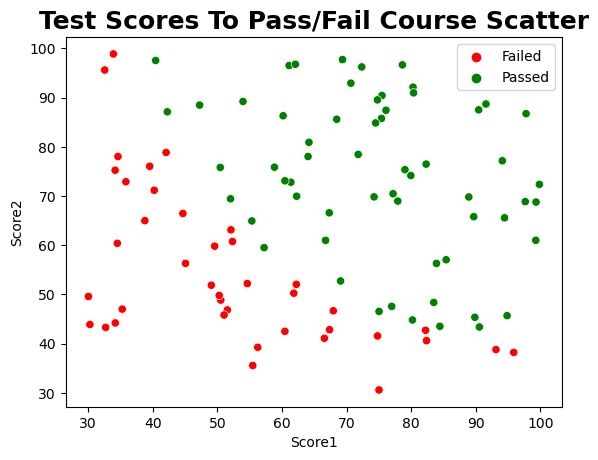

In [108]:
single_variable_model = LogisticRegressionModel(
    dataset=q1_df,
    epsilon=1e-5,
    asc_threshold=1)
single_variable_model.scatter_plot_dataset()

Sigmoid graph example

Text(0.5, 1.0, 'Sigmoid Function')

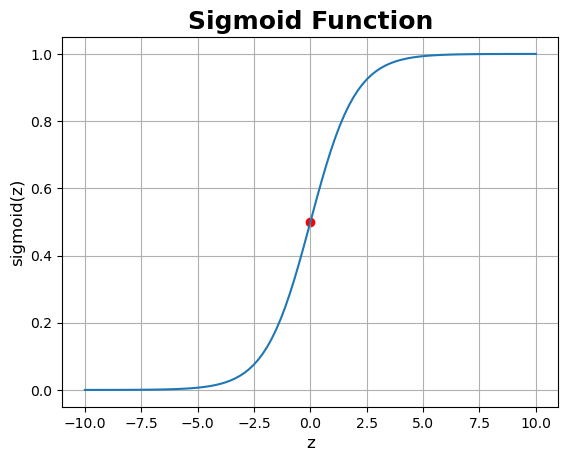

In [109]:
z = np.linspace(-10,10,100)
y = Utils.sigmoid(z)
plt.plot(z,y)
plt.grid()
plt.scatter(0, 0.5, color='red')
plt.xlabel('z', size=12)
plt.ylabel('sigmoid(z)', size=12)
plt.title('Sigmoid Function', size=18,  fontweight='bold')

Train Logistic Regression Model for data set #1

In [110]:
single_variable_model.train_model(plot_cost_graph=True)

c:\Users\galsa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\galsa\AppData\Local\Temp\ipykernel_35028\4202171051.py:89: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(gradient, dtype=np.float64).reshape(weights.shape[0], 1)


Cost function ascending detected!
New cost: 37325.773771986685, Last cost: 37325.769629253664


Plot decition boundary

TypeError: 'NoneType' object is not subscriptable

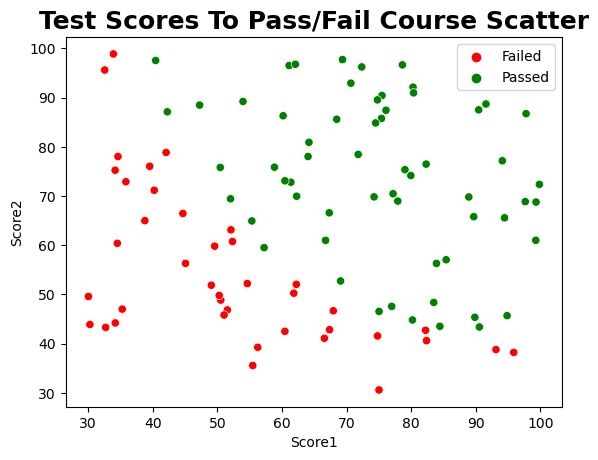

In [111]:
single_variable_model.scatter_plot_dataset()
single_variable_model.plot_decision_boundary_2D()

Model evaluation

In [82]:
Utils.reset_variables()
x = Utils.get_x_vals(q1_df)
y = Utils.get_y_vals(q1_df, x)
acc = single_variable_model.accuracy(x, y, threshold=0.5)
print(f'model has accuracy of {acc}%')

model has accuracy of 85.0%


New samples plot

# Q2: Logistic Regression with regularization

checking the shape of the mapfeature

In [ ]:
x,y = Utils.map_feature(q2_df,6)
print(x.shape)
print(Utils.map_feature(q2_df, 6))

Scatter plot of the second data file 

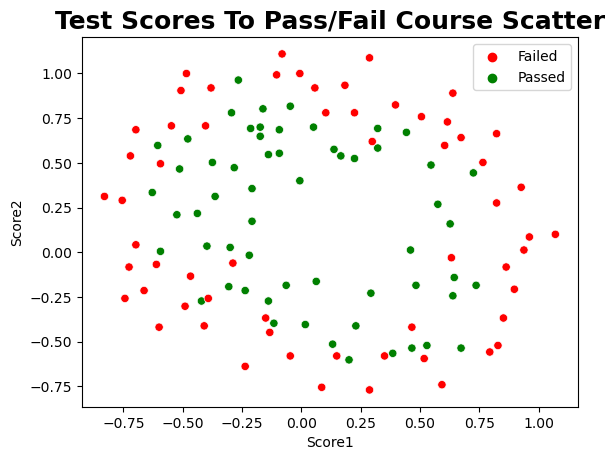

In [8]:
single_variable_model = LogisticRegressionModel(
    dataset=q2_df,
    epsilon=1e-5,
    _lambda=0.1)
single_variable_model.scatter_plot_dataset()